Importing Packages & Dataset


In [105]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, plot_confusion_matrix, roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb


%matplotlib inline

In [61]:
from google.colab import files
uploaded = files.upload()
import io
dataset = pd.read_csv(io.BytesIO(uploaded['weatherAUS.csv']))

Saving weatherAUS.csv to weatherAUS (1).csv


In [62]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [63]:
dataset.shape

(145460, 23)

In [64]:
df=dataset
#We keep the originally imported dataset aside so that we can go ahead and experiment with the copies while not manipulating our dataset in case we need to load it again after some mistakes.
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [65]:
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

Missing Values in Target Variable "RainTomorrow" = 3267

In [66]:
df['RainTomorrow'].value_counts()

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

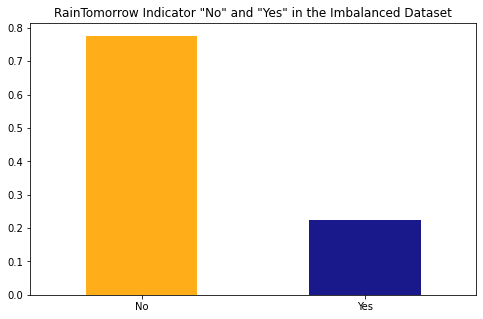

In [67]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['orange','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator "No" and "Yes" in the Imbalanced Dataset')
plt.show()

In [68]:
(df['RainTomorrow'].value_counts()/len(df))*100

No     75.839406
Yes    21.914616
Name: RainTomorrow, dtype: float64

Evidently, with 3267 missing values in the target variable, the dataset appears to be imbalanced favoring 'NO' : 'Yes' with 75.83% : 21.91% 

We will treat the dataset for missing values irrespective of the target variables missing values, and later create a subset to fill the NA with the most accurate model.

In [69]:
target = df['RainTomorrow']
df1 = df.drop(['RainTomorrow'], axis=1)
df1.shape

(145460, 22)

In [ ]:
#df['Date'] = pd.to_datetime(df['Date'])
# extract year from date
#df['Year'] = df['Date'].dt.year
#df['Month'] = df['Date'].dt.month
#df['Day'] = df['Date'].dt.day

#df.shape



In [70]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

We'll create a table and check for the percent of missing values and upon further exploration decide whether we should drop them or impute their missing values.

We will use a heat map visualization for better understanding of missing values in features.

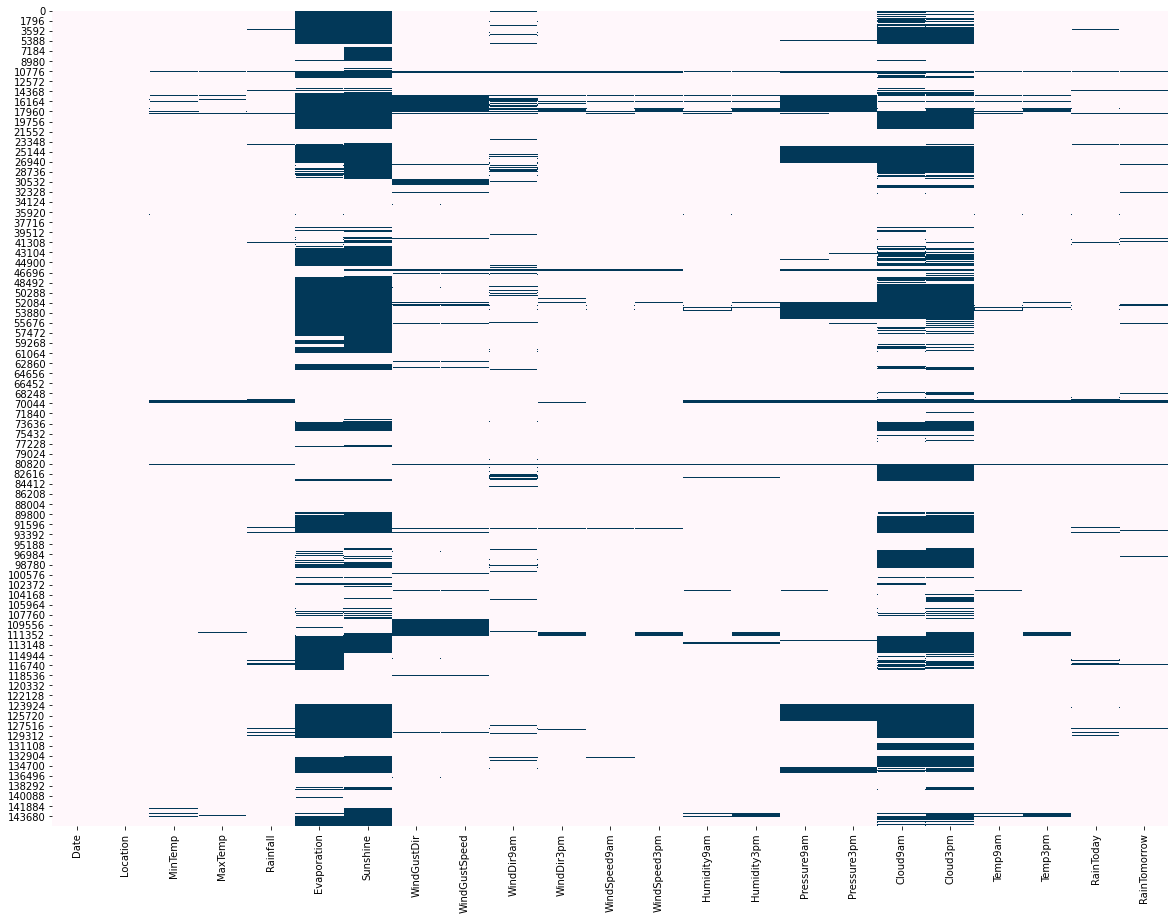

In [71]:
import seaborn as sns
plt.subplots(figsize=(20,15))
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu', vmin=0, vmax=1 )

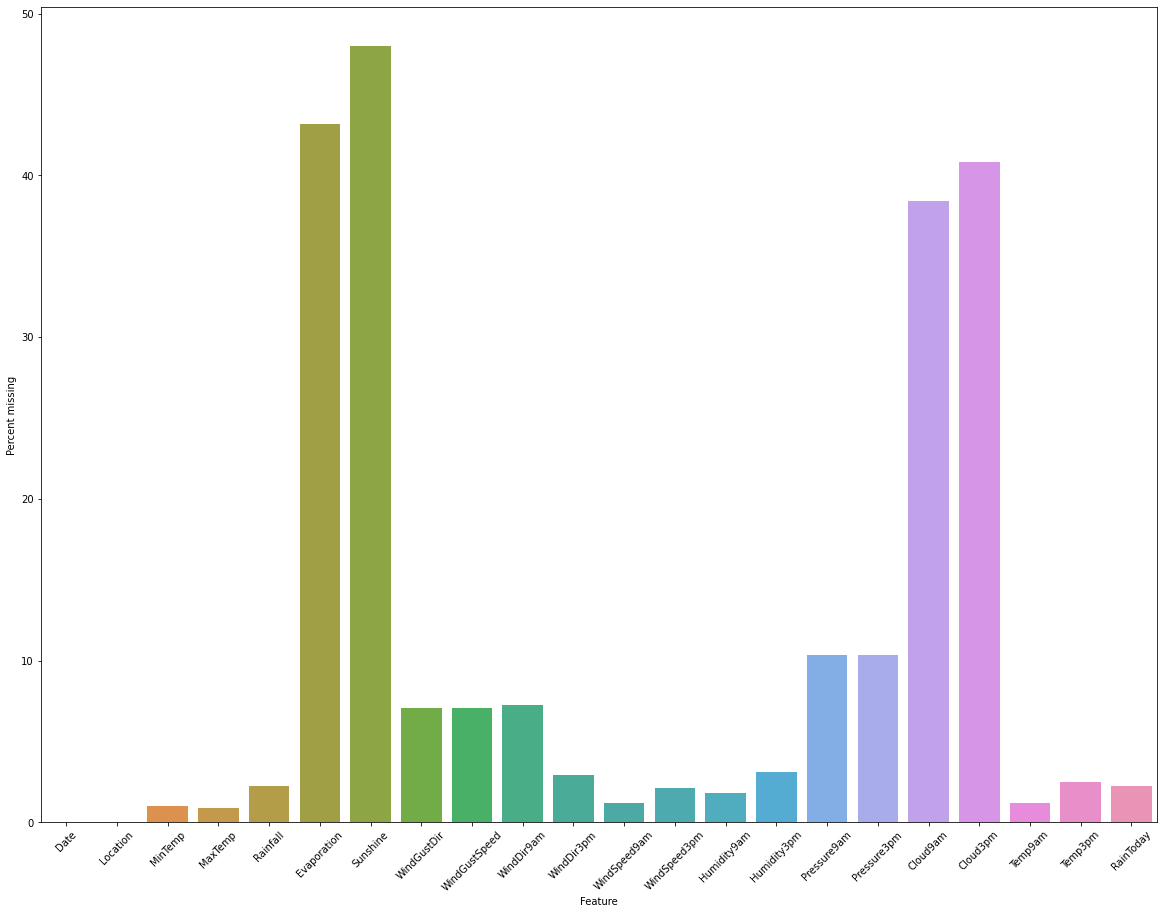

In [72]:
null_vals = df1.isnull().sum()/len(df1)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (20,15))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing", data = null_vals)

Therefore Evaporation, Sunshine, Cloud9am and Cloud3pm have most missing values.

In [73]:
missing_values=df1.isnull().sum() # missing values

percent_missing = df1.isnull().sum()/df1.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : df1.dtypes
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %,data type
Date,0,0.000000,object
Location,0,0.000000,object
MinTemp,1485,1.020899,float64
MaxTemp,1261,0.866905,float64
Rainfall,3261,2.241853,float64
Evaporation,62790,43.166506,float64
Sunshine,69835,48.009762,float64
WindGustDir,10326,7.098859,object
WindGustSpeed,10263,7.055548,float64
WindDir9am,10566,7.263853,object


In [74]:
numVars = [var for var in df1.columns if df1[var].dtype!='O']

print('There are {} numerical variables\n'.format(len(numVars)), '\n', numVars)

There are 16 numerical variables
 
 ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


Since Evaporation, Sunshine, Cloud9am and Cloud3pm are the ones with most missing values and are numerical they shall be treated accordingly.

Hence for numerical imputation we'll go ahead and store data in different dataframes each imputed with different methods to check for better accuracy.

Methods used for imputation:


1.   Median
2.   Iterative Imputer
3.   k-NN Imputer





In [75]:
df_num1 = df1[numVars] #Median Imputation
df_num2 = df1[numVars]

In [76]:
#Median Imputation
for m in [df_num1]:
    for col in numVars:
        med = df_num1[col].median()
        m[col].fillna(med, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [77]:
df_num1.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [78]:
#Iterative Imputation
itimp = IterativeImputer(random_state=0)
d=itimp.fit_transform(df_num2)
df_itimp = pd.DataFrame(d, columns=df_num2.columns)
df_itimp.isna().sum()

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [ ]:
#kNN Imputation
imputer = KNNImputer(n_neighbors=2, weights="uniform")
k = imputer.fit_transform(df_num2)
df_knn = pd.DataFrame(k, columns=df_num2.columns)
df_knn.isna().sum()


Similarly, checking the categorical features for missing values and frequency of unique values to estimate the dummy variables that may be needed during encoding

In [79]:
catVars = [var for var in df1.columns if df1[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(catVars)), '\n', catVars)

There are 6 categorical variables
 
 ['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [80]:
df1[catVars].isna().sum()

Date               0
Location           0
WindGustDir    10326
WindDir9am     10566
WindDir3pm      4228
RainToday       3261
dtype: int64

In [81]:
df_cat = df1[catVars]

Filling NA in categorical variables with Mode values.

In [82]:
df_cat['WindGustDir'].fillna(df_cat['WindGustDir'].mode()[0], inplace=True)
df_cat['WindDir9am'].fillna(df_cat['WindDir9am'].mode()[0], inplace=True)
df_cat['WindDir3pm'].fillna(df_cat['WindDir3pm'].mode()[0], inplace=True)
df_cat['RainToday'].fillna(df_cat['RainToday'].mode()[0], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [83]:
for c in catVars:
    
    print(c, ':', len(df_cat[c].unique()), 'Unique Values')

Date : 3436 Unique Values
Location : 49 Unique Values
WindGustDir : 16 Unique Values
WindDir9am : 16 Unique Values
WindDir3pm : 16 Unique Values
RainToday : 2 Unique Values


High Cardinality observed in Date column. Therefore we shall break down dates in years, months and days values, since it has no missing values

Sum of total dummy variables therefore shall be 48 (Location), 15 (WindGustDir), 15 (WindDir9am), 15 (WindDir3pm) and 1 (RainToday) = 94.

Check frequency and sum dummy vars needed and break down dates before scaling

In [84]:
df_cat.isna().sum()

Date           0
Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64

Since imputing with kNN imputer took almost an hour, we believe there are outliers in the numerical features. Therefore we shall check for outliers and impute again if need be.

In [85]:
df1[numVars].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


Outliers observed in Rainfall, Evaporation, WindSpeed9am and WindSpeed3pm. Lets check on the box-plot visualization.

Text(0, 0.5, 'WindSpeed3pm')

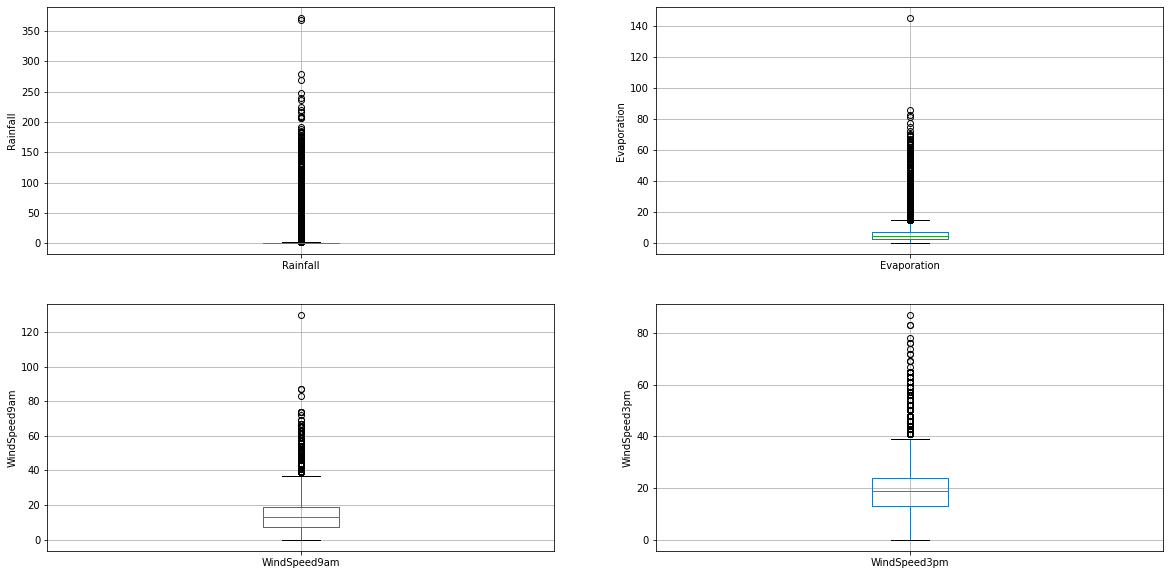

In [87]:
#box plot each of the above
plt.figure(figsize=(20,10))


plt.subplot(2, 2, 1)
fig = df1.boxplot(column='Rainfall')
fig.set_title('')
fig.set_ylabel('Rainfall')


plt.subplot(2, 2, 2)
fig = df1.boxplot(column='Evaporation')
fig.set_title('')
fig.set_ylabel('Evaporation')


plt.subplot(2, 2, 3)
fig = df1.boxplot(column='WindSpeed9am')
fig.set_title('')
fig.set_ylabel('WindSpeed9am')


plt.subplot(2, 2, 4)
fig = df1.boxplot(column='WindSpeed3pm')
fig.set_title('')
fig.set_ylabel('WindSpeed3pm')

Calculating Upper fences for Rainfall variable

In [88]:
Q1 = df1.Rainfall.quantile(0.25)
Q3 = df1.Rainfall.quantile(0.75)
IQR = Q3 - Q1
Lower_fence = Q1 - (IQR * 1.5)
Upper_fence = Q3 + (IQR * 1.5)
print('Rainfall fences are: < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Rainfall fences are: < -1.2000000000000002 or > 2.0


Calculating Upper fences for Evaporation variable


In [89]:
Q1 = df1.Evaporation.quantile(0.25)
Q3 = df1.Evaporation.quantile(0.75)
IQR = Q3 - Q1
Lower_fence = Q1 - (IQR * 1.5)
Upper_fence = Q3 + (IQR * 1.5)
print('Evaporation outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

Evaporation outliers are values < -4.600000000000001 or > 14.600000000000001


Calculating Upper fences for WindSpeed9am variable

In [90]:

Q1 = df1.WindSpeed9am.quantile(0.25)
Q3 = df1.WindSpeed9am.quantile(0.75)
IQR = Q3 - Q1
Lower_fence = Q1 - (IQR * 1.5)
Upper_fence = Q3 + (IQR * 1.5)
print('WindSpeed9am outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

WindSpeed9am outliers are values < -11.0 or > 37.0


Calculating Upper fences for WindSpeed3pm variable

In [91]:

Q1 = df1.WindSpeed3pm.quantile(0.25)
Q3 = df1.WindSpeed3pm.quantile(0.75)
IQR = Q3 - Q1
Lower_fence = Q1 - (IQR * 1.5)
Upper_fence = Q3 + (IQR * 1.5)
print('WindSpeed3pm outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=Lower_fence, upperboundary=Upper_fence))

WindSpeed3pm outliers are values < -3.5 or > 40.5


In [92]:
def max_value(df1, variable, top):
    return np.where(df1[variable]>top, top, df1[variable])

for df1 in [df1]:
    df1['Rainfall'] = max_value(df1, 'Rainfall', 2.0)
    df1['Evaporation'] = max_value(df1, 'Evaporation', 14.6)
    df1['WindSpeed9am'] = max_value(df1, 'WindSpeed9am', 37.0)
    df1['WindSpeed3pm'] = max_value(df1, 'WindSpeed3pm', 40.5)

In [93]:
df1[numVars].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,0.487224,5.318667,7.611178,40.035230,13.951313,18.574162,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,0.792809,3.418079,3.785483,13.607062,8.607783,8.532467,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,2.000000,14.600000,14.500000,135.000000,37.000000,40.500000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


In [94]:
df1.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
dtype: int64

Imputing the missing values in numerical features again.

In [95]:
df_num3 = df1[numVars]
df_num4 = df1[numVars]

In [96]:
#Median Imputation
for m in [df_num3]:
    for col in numVars:
        med = df_num3[col].median()
        m[col].fillna(med, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [97]:
df_num3.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [98]:
#Iterative Imputation
itimp = IterativeImputer(random_state=0)
d=itimp.fit_transform(df_num4)
df_itimp = pd.DataFrame(d, columns=df_num4.columns)
df_itimp.isna().sum()

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

In [ ]:
#kNN Imputation
imputer = KNNImputer(n_neighbors=2, weights="uniform")
k = imputer.fit_transform(df_num4)
df_knn = pd.DataFrame(k, columns=df_num4.columns)
df_knn.isna().sum()

In [167]:
a = [df_num3,df_cat]
X1 = pd.concat(a, axis = 1) #Median Imputed
b = [df_itimp,df_cat]
X2 = pd.concat(b, axis = 1) #Iteratively Imputed

In [168]:
X1.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
0,13.4,22.9,0.6,4.8,8.4,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,2008-12-01,Albury,W,W,WNW,No
1,7.4,25.1,0.0,4.8,8.4,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,2008-12-02,Albury,WNW,NNW,WSW,No
2,12.9,25.7,0.0,4.8,8.4,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,2008-12-03,Albury,WSW,W,WSW,No
3,9.2,28.0,0.0,4.8,8.4,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,2008-12-04,Albury,NE,SE,E,No
4,17.5,32.3,1.0,4.8,8.4,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,2008-12-05,Albury,W,ENE,NW,No


Concatenating the target variable with X1 and X2 to resample the data, following which we shall check the correlation of numerical features.

In [169]:
X1 = pd.concat([X1,target], axis=1)
X2 = pd.concat([X2,target], axis=1)
print(X1.shape, X2.shape)

(145460, 23) (145460, 23)


In [170]:
X1['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

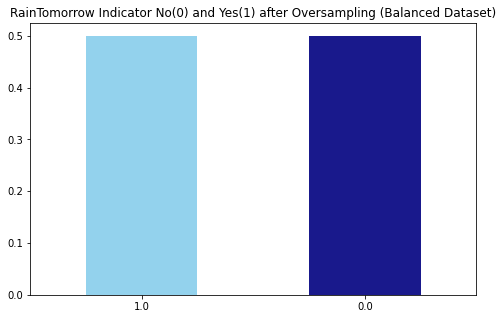

In [171]:
from sklearn.utils import resample

no = X1[X1.RainTomorrow == 0]
yes = X1[X1.RainTomorrow == 1]
oversample_yes = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled_X1 = pd.concat([no, oversample_yes])

fig = plt.figure(figsize = (8,5))
oversampled_X1.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

In [172]:
X2['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

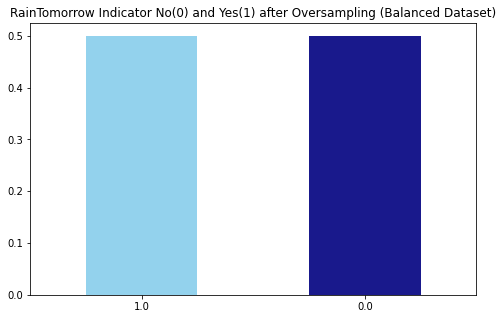

In [173]:
no = X2[X2.RainTomorrow == 0]
yes = X2[X2.RainTomorrow == 1]
oversample_yes = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled_X2 = pd.concat([no, oversample_yes])

fig = plt.figure(figsize = (8,5))
oversampled_X2.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

Lets check the correlation on a heat map to get a better understanding of which features are highly inter-dependent and process them accordingly in the processed dataframe

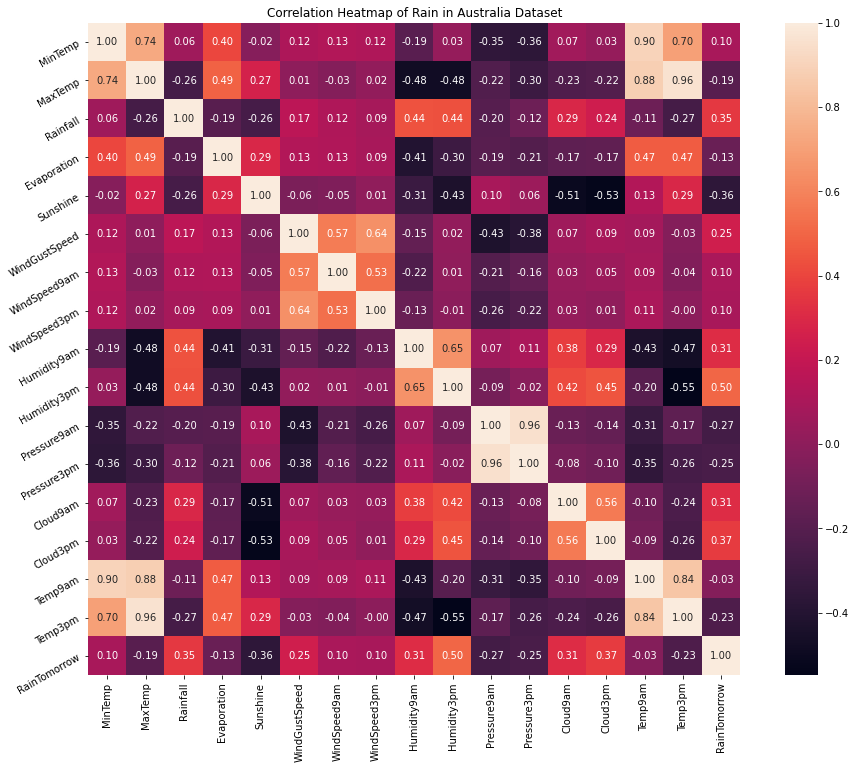

In [174]:
X1 = oversampled_X1

correlation = X1.corr()
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Rain in Australia Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

In [175]:
X1.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Date             0
Location         0
WindGustDir      0
WindDir9am       0
WindDir3pm       0
RainToday        0
RainTomorrow     0
dtype: int64

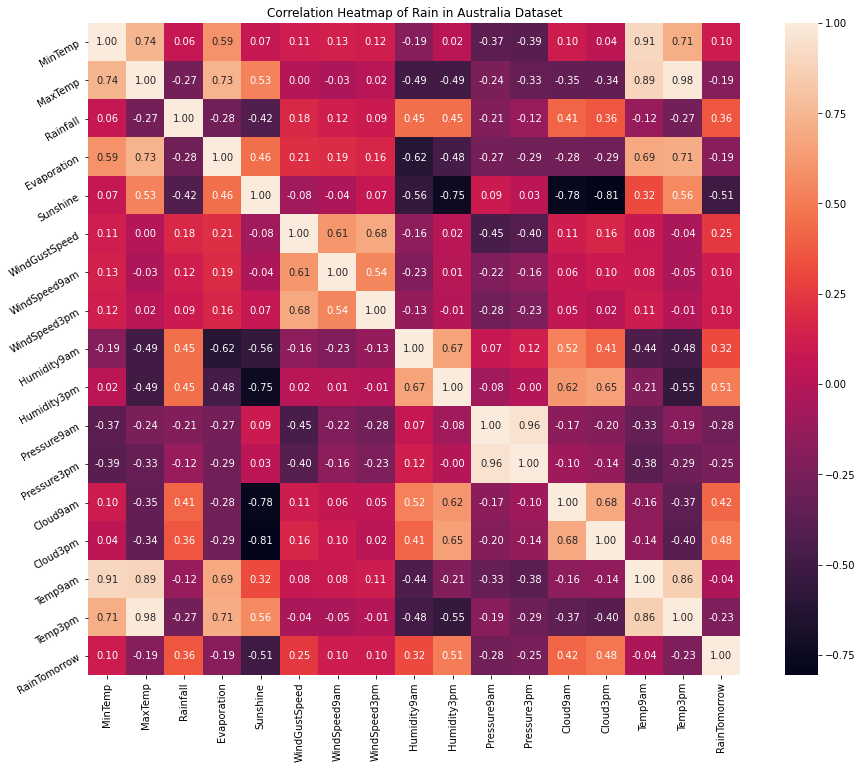

In [176]:
X2 = oversampled_X2

correlation = X2.corr()
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Rain in Australia Dataset')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

In [177]:
X2.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
Date             0
Location         0
WindGustDir      0
WindDir9am       0
WindDir3pm       0
RainToday        0
RainTomorrow     0
dtype: int64

In [178]:
Y1 = X1[['RainTomorrow']]

In [179]:
X1 = pd.concat([X1['Date'], X1[numVars],
                     pd.get_dummies(X1.Location), 
                     pd.get_dummies(X1.WindGustDir),
                     pd.get_dummies(X1.WindDir9am),
                     pd.get_dummies(X1.WindDir3pm)], axis=1)



In [180]:
X1.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,...,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,2008-12-01,13.4,22.9,0.6,4.8,8.4,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2008-12-02,7.4,25.1,0.0,4.8,8.4,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2008-12-03,12.9,25.7,0.0,4.8,8.4,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2008-12-04,9.2,28.0,0.0,4.8,8.4,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2008-12-05,17.5,32.3,1.0,4.8,8.4,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [181]:
Y2 = X2[['RainTomorrow']]

In [183]:
X2 = pd.concat([X2['Date'], X2[numVars],
                     pd.get_dummies(X2.Location), 
                     pd.get_dummies(X2.WindGustDir),
                     pd.get_dummies(X2.WindDir9am),
                     pd.get_dummies(X2.WindDir3pm)], axis=1)

In [184]:
X2.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,...,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,2008-12-01,13.4,22.9,0.6,6.191156,7.019579,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,5.122632,16.9,21.8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2008-12-02,7.4,25.1,0.0,6.109107,10.914483,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,1.892549,2.609514,17.2,24.3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2008-12-03,12.9,25.7,0.0,8.382008,11.880040,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,1.995413,2.000000,21.0,23.2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2008-12-04,9.2,28.0,0.0,6.412913,11.573287,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,1.189312,2.000929,18.1,26.5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2008-12-05,17.5,32.3,1.0,6.768763,5.383981,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [185]:
X1 = X1.drop(['Date'], axis=1)
X2 = X2.drop(['Date'], axis=1)

Scaling the df_itimp, df_knn and df_num3 for easier model building using Standard Scaler.

In [188]:
scaler = StandardScaler()
d1 = pd.DataFrame(scaler.fit_transform(X1))
d1.columns = X1.columns


In [189]:
d1.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,...,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0.138114,0.062623,-0.058649,-0.047307,0.332197,0.153105,0.638819,0.567686,-0.057623,-1.646097,-1.274125,-1.039931,1.345216,-0.057453,0.006618,0.146282,-0.148684,-0.155821,6.891339,-0.129065,-0.142218,-0.151259,-0.142863,-0.151838,-0.156977,-0.152275,-0.136264,-0.154042,-0.156415,-0.156263,-0.149494,-0.153779,-0.099247,-0.149415,-0.13552,-0.14576,-0.132913,-0.132347,-0.156339,-0.15071,...,-0.258962,-0.255144,-0.254024,-0.253377,-0.252474,2.443697,-0.256663,-0.259887,-0.243055,-0.230273,-0.221281,-0.433045,-0.23356,-0.249843,-0.259042,-0.264272,-0.246881,-0.24929,-0.249136,-0.234928,-0.249771,3.899826,-0.238685,-0.228455,-0.237665,-0.229836,-0.238292,-0.266747,-0.240546,-0.220943,-0.250446,-0.263467,-0.26774,-0.333986,-0.256422,-0.244162,-0.256622,-0.280527,3.779907,-0.265135
1,-0.803247,0.372254,-0.747024,-0.047307,0.332197,0.153105,-1.187521,0.339185,-1.520975,-1.506853,-0.859133,-0.938903,-0.013397,-0.057453,0.053298,0.510354,-0.148684,-0.155821,6.891339,-0.129065,-0.142218,-0.151259,-0.142863,-0.151838,-0.156977,-0.152275,-0.136264,-0.154042,-0.156415,-0.156263,-0.149494,-0.153779,-0.099247,-0.149415,-0.13552,-0.14576,-0.132913,-0.132347,-0.156339,-0.15071,...,-0.258962,-0.255144,-0.254024,-0.253377,-0.252474,-0.409216,3.896166,-0.259887,-0.243055,-0.230273,-0.221281,-0.433045,-0.23356,-0.249843,3.860382,-0.264272,-0.246881,-0.24929,-0.249136,-0.234928,-0.249771,-0.256422,-0.238685,-0.228455,-0.237665,-0.229836,-0.238292,-0.266747,-0.240546,-0.220943,-0.250446,-0.263467,-0.26774,-0.333986,-0.256422,-0.244162,-0.256622,-0.280527,-0.264557,3.771664
2,0.059667,0.456699,-0.747024,-0.047307,0.332197,0.294637,0.524673,0.796186,-1.846164,-1.274779,-1.288435,-0.809011,-0.013397,-1.519066,0.644578,0.350162,-0.148684,-0.155821,6.891339,-0.129065,-0.142218,-0.151259,-0.142863,-0.151838,-0.156977,-0.152275,-0.136264,-0.154042,-0.156415,-0.156263,-0.149494,-0.153779,-0.099247,-0.149415,-0.13552,-0.14576,-0.132913,-0.132347,-0.156339,-0.15071,...,-0.258962,-0.255144,-0.254024,-0.253377,-0.252474,-0.409216,-0.256663,3.847820,-0.243055,-0.230273,-0.221281,-0.433045,-0.23356,-0.249843,-0.259042,-0.264272,-0.246881,-0.24929,-0.249136,-0.234928,-0.249771,3.899826,-0.238685,-0.228455,-0.237665,-0.229836,-0.238292,-0.266747,-0.240546,-0.220943,-0.250446,-0.263467,-0.26774,-0.333986,-0.256422,-0.244162,-0.256622,-0.280527,-0.264557,3.771664
3,-0.520839,0.780405,-0.747024,-0.047307,0.332197,-1.262208,-0.388497,-1.146069,-1.466777,-1.924585,0.142571,-0.217277,-0.013397,-0.057453,0.193338,0.830737,-0.148684,-0.155821,6.891339,-0.129065,-0.142218,-0.151259,-0.142863,-0.151838,-0.156977,-0.152275,-0.136264,-0.154042,-0.156415,-0.156263,-0.149494,-0.153779,-0.099247,-0.149415,-0.13552,-0.14576,-0.132913,-0.132347,-0.156339,-0.15071,...,-0.258962,-0.255144,-0.254024,-0.253377,-0.252474,-0.409216,-0.256663,-0.259887,-0.243055,-0.230273,-0.221281,-0.433045,-0.23356,-0.249843,-0.259042,-0.264272,-0.246881,4.01140,-0.249136,-0.234928,-0.249771,-0.256422,-0.238685,-0.228455,4.207608,-0.229836,-0.238292,-0.266747,-0.240546,-0.220943,-0.250446,-0.263467,-0.26774,-0.333986,-0.256422,-0.244162,-0.256622,-0.280527,-0.264557,-0.265135
4,0.781378,1.385593,0.400269,-0.047307,0.332197,-0.059192,-0.845082,0.110685,0.538558,-1.135535,-0.830513,-1.198689,0.892345,1.404159,0.146658,1.296749,-0.148684,-0.155821,6.891339,-0.129065,-0.142218,-0.151259,-0.142863,-0.151838,-0.156977,-0.152275,-0.136264,-0.154042,-0.156415,-0.156263,-0.149494,-0.15377

In [193]:
d1.shape

(220632, 113)

In [190]:
scaler = StandardScaler()
d2 = pd.DataFrame(scaler.fit_transform(X2))
d2.columns = X2.columns
d2.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,...,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0.137381,0.062564,-0.069580,0.502483,0.168687,0.156573,0.636579,0.566226,-0.063439,-1.641375,-1.271342,-1.041028,1.215182,0.006854,0.011592,0.142093,-0.148684,-0.155821,6.891339,-0.129065,-0.142218,-0.151259,-0.142863,-0.151838,-0.156977,-0.152275,-0.136264,-0.154042,-0.156415,-0.156263,-0.149494,-0.153779,-0.099247,-0.149415,-0.13552,-0.14576,-0.132913,-0.132347,-0.156339,-0.15071,...,-0.258962,-0.255144,-0.254024,-0.253377,-0.252474,2.443697,-0.256663,-0.259887,-0.243055,-0.230273,-0.221281,-0.433045,-0.23356,-0.249843,-0.259042,-0.264272,-0.246881,-0.24929,-0.249136,-0.234928,-0.249771,3.899826,-0.238685,-0.228455,-0.237665,-0.229836,-0.238292,-0.266747,-0.240546,-0.220943,-0.250446,-0.263467,-0.26774,-0.333986,-0.256422,-0.244162,-0.256622,-0.280527,3.779907,-0.265135
1,-0.802472,0.371984,-0.759555,0.475733,1.249603,0.156573,-1.187140,0.338601,-1.517346,-1.503314,-0.859563,-0.940820,-1.221513,-1.063514,0.057925,0.499934,-0.148684,-0.155821,6.891339,-0.129065,-0.142218,-0.151259,-0.142863,-0.151838,-0.156977,-0.152275,-0.136264,-0.154042,-0.156415,-0.156263,-0.149494,-0.153779,-0.099247,-0.149415,-0.13552,-0.14576,-0.132913,-0.132347,-0.156339,-0.15071,...,-0.258962,-0.255144,-0.254024,-0.253377,-0.252474,-0.409216,3.896166,-0.259887,-0.243055,-0.230273,-0.221281,-0.433045,-0.23356,-0.249843,3.860382,-0.264272,-0.246881,-0.24929,-0.249136,-0.234928,-0.249771,-0.256422,-0.238685,-0.228455,-0.237665,-0.229836,-0.238292,-0.266747,-0.240546,-0.220943,-0.250446,-0.263467,-0.26774,-0.333986,-0.256422,-0.244162,-0.256622,-0.280527,-0.264557,3.771664
2,0.059060,0.456371,-0.759555,1.216746,1.517565,0.294487,0.522597,0.793850,-1.840436,-1.273211,-1.285541,-0.811982,-1.180473,-1.323114,0.644814,0.342484,-0.148684,-0.155821,6.891339,-0.129065,-0.142218,-0.151259,-0.142863,-0.151838,-0.156977,-0.152275,-0.136264,-0.154042,-0.156415,-0.156263,-0.149494,-0.153779,-0.099247,-0.149415,-0.13552,-0.14576,-0.132913,-0.132347,-0.156339,-0.15071,...,-0.258962,-0.255144,-0.254024,-0.253377,-0.252474,-0.409216,-0.256663,3.847820,-0.243055,-0.230273,-0.221281,-0.433045,-0.23356,-0.249843,-0.259042,-0.264272,-0.246881,-0.24929,-0.249136,-0.234928,-0.249771,3.899826,-0.238685,-0.228455,-0.237665,-0.229836,-0.238292,-0.266747,-0.240546,-0.220943,-0.250446,-0.263467,-0.26774,-0.333986,-0.256422,-0.244162,-0.256622,-0.280527,-0.264557,3.771664
3,-0.520516,0.779855,-0.759555,0.574780,1.432434,-1.222567,-0.389263,-1.140959,-1.463498,-1.917498,0.134387,-0.225052,-1.502083,-1.322718,0.196925,0.814834,-0.148684,-0.155821,6.891339,-0.129065,-0.142218,-0.151259,-0.142863,-0.151838,-0.156977,-0.152275,-0.136264,-0.154042,-0.156415,-0.156263,-0.149494,-0.153779,-0.099247,-0.149415,-0.13552,-0.14576,-0.132913,-0.132347,-0.156339,-0.15071,...,-0.258962,-0.255144,-0.254024,-0.253377,-0.252474,-0.409216,-0.256663,-0.259887,-0.243055,-0.230273,-0.221281,-0.433045,-0.23356,-0.249843,-0.259042,-0.264272,-0.246881,4.01140,-0.249136,-0.234928,-0.249771,-0.256422,-0.238685,-0.228455,4.207608,-0.229836,-0.238292,-0.266747,-0.240546,-0.220943,-0.250446,-0.263467,-0.26774,-0.333986,-0.256422,-0.244162,-0.256622,-0.280527,-0.264557,-0.265135
4,0.779614,1.384630,0.390403,0.690795,-0.285225,-0.050298,-0.845192,0.110976,0.528894,-1.135150,-0.831164,-1.198497,0.816211,1.232362,0.150592,1.272870,-0.148684,-0.155821,6.891339,-0.129065,-0.142218,-0.151259,-0.142863,-0.151838,-0.156977,-0.152275,-0.136264,-0.154042,-0.156415,-0.156263,-0.149494,-0.153779,-0.


1. d1 = Median Imputed dataset

2. d2 = Iteratively Imputed dataset




# Working with d1 dataset

In [229]:
Xtv, Xt = train_test_split(d1, test_size=0.15, random_state=123, shuffle=True, stratify=None)
Ytv, Yt = train_test_split(Y1, test_size=0.15, random_state=123, shuffle=True, stratify=None)
print(Xtv.shape, Xt.shape, Ytv.shape, Yt.shape)

(187537, 113) (33095, 113) (187537, 1) (33095, 1)


In [231]:
Xtr, Xv = train_test_split(Xtv, test_size=0.15, random_state=123, shuffle=True, stratify=None)
Ytr, Yv = train_test_split(Ytv, test_size=0.15, random_state=123, shuffle=True, stratify=None)
print(Xtr.shape, Xv.shape, Ytr.shape, Yv.shape)

(159406, 113) (28131, 113) (159406, 1) (28131, 1)


# Decision Tree Classifier:

In [232]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)

model_dt.fit(Xtr,Ytr)

y_prd = model_dt.predict(Xv)
accuracy_score(Yv,y_prd)


0.7794959297572074

In [241]:
#Test Case Accuracy:
yt_prd = model_dt.predict(Xt)
accuracy_score(Yt,yt_prd)


0.7867653724127511

Thus the accuracy of Decision tree classifier model on test set is 78.67%

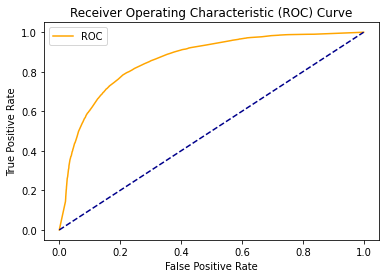

In [242]:
roc_auc = roc_auc_score(Yt, yt_prd)
probs = model_dt.predict_proba(Xt)  
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(Yt, probs) 
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Random Forest Classifier:

In [251]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)

In [252]:
model_rf.fit(Xtr,Ytr)
y_prd1 = model_rf.predict(Xv)
accuracy_score(Yv,y_prd1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


0.8468948846468309

In [253]:
y_prd = model_rf.predict(Xt)
accuracy_score(Yt,y_prd)

0.8536636954222693

Thus the accuracy of Random Forest Classifier model is **85.36%**.
Now we'll check for feature importance and thereby derive most prime features using which we will train and test the Random Forest classifier again.

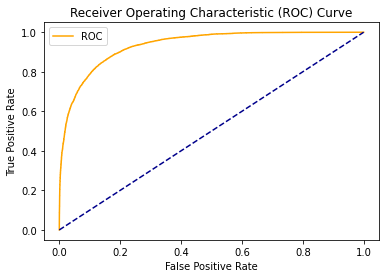

In [254]:
roc_auc = roc_auc_score(Yt, y_prd)
probs = model_rf.predict_proba(Xt)  
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(Yt, probs) 
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

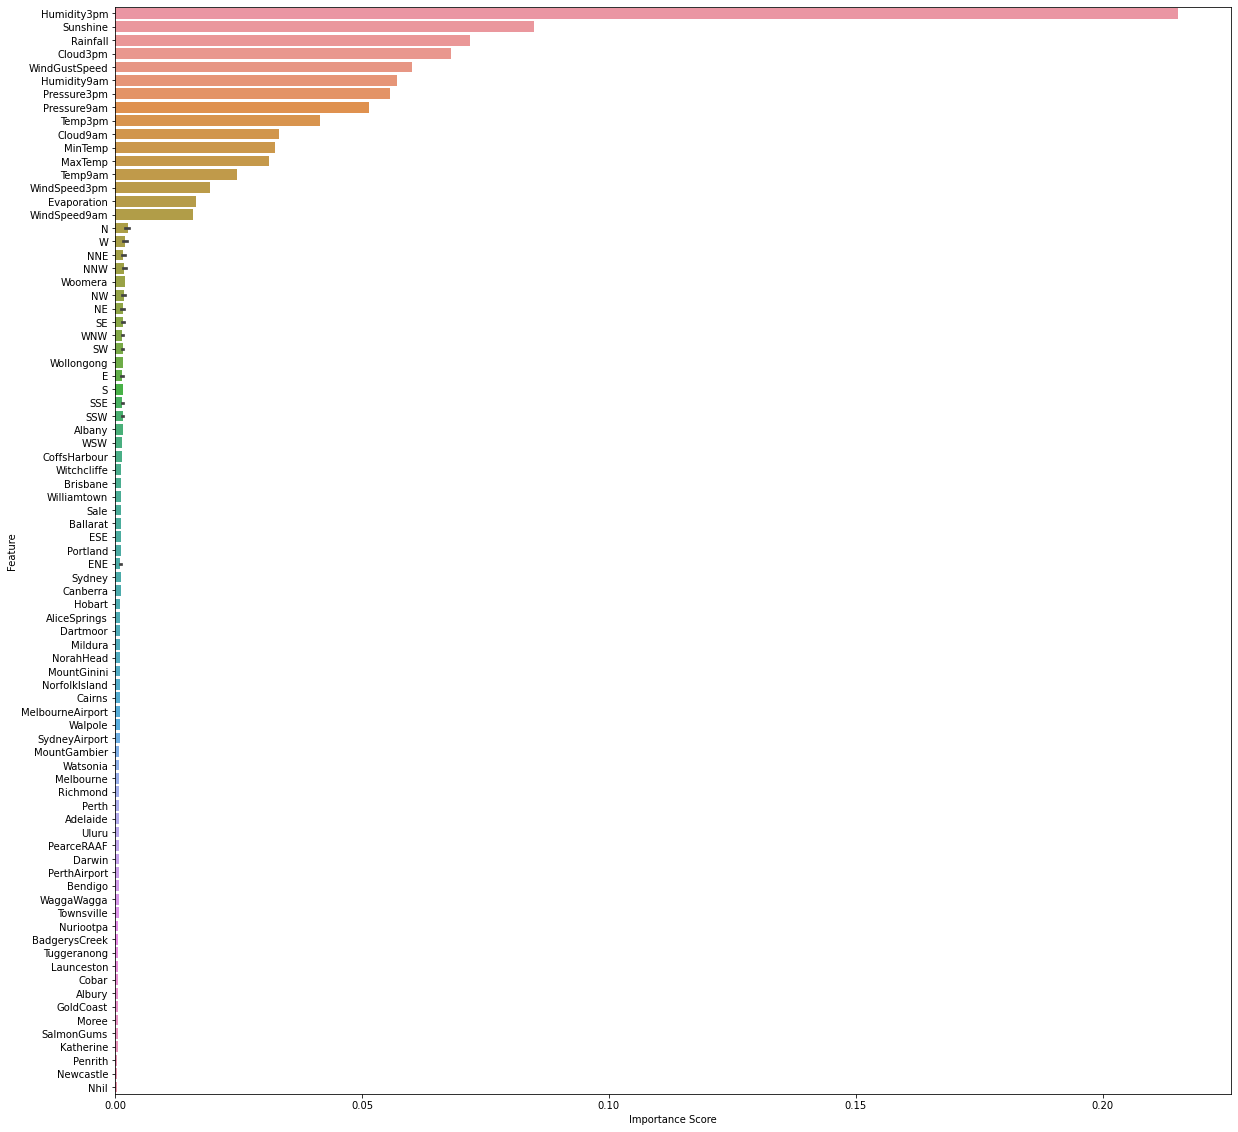

In [245]:
feat_imps = pd.DataFrame(model_rf.feature_importances_, index = Xtr.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (20,20))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")

Thereby we'll drop the features that have lower importance than the feature WindSpeed9am

In [246]:
Xnew = Xtr[['WindSpeed9am', 'Evaporation', 'WindSpeed3pm', 'Temp9am','Cloud9am', 'MinTemp', 'MaxTemp', 'Temp3pm', 'Pressure9am', 'Humidity9am', 'Pressure3pm','WindGustSpeed','Cloud3pm','Rainfall','Sunshine','Humidity3pm']]
Xvn = Xv[['WindSpeed9am', 'Evaporation', 'WindSpeed3pm', 'Temp9am','Cloud9am', 'MinTemp', 'MaxTemp', 'Temp3pm', 'Pressure9am', 'Humidity9am', 'Pressure3pm','WindGustSpeed','Cloud3pm','Rainfall','Sunshine','Humidity3pm']]


In [262]:
model_rf.fit(Xnew,Ytr)
yv_prd1 = model_rf.predict(Xvn)
accuracy_score(Yv,yv_prd1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


0.8843624471223916

In [263]:
Xtn = Xt[['WindSpeed9am', 'Evaporation', 'WindSpeed3pm', 'Temp9am','Cloud9am', 'MinTemp', 'MaxTemp', 'Temp3pm', 'Pressure9am', 'Humidity9am', 'Pressure3pm','WindGustSpeed','Cloud3pm','Rainfall','Sunshine','Humidity3pm']]
yt_prd1 = model_rf.predict(Xtn)
accuracy_score(Yt,yt_prd1)

0.8912222390089137

In [259]:
yt_prd1.shape

(28131,)

Therefore we see that using feature importance plot and function we have derived prime features that tends to accurately predict the target variable with an accuracy of **89%**.

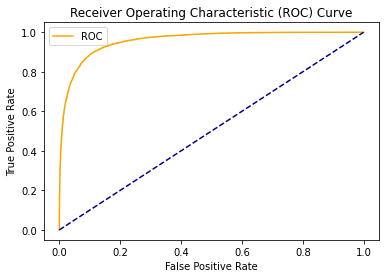

In [265]:
roc_auc = roc_auc_score(Yt,yt_prd1)
probs = model_rf.predict_proba(Xtn)  
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(Yt, probs) 
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Build and compile a deep learning model

In [194]:
from keras.models import Sequential
from keras.layers import Dense

In [196]:
# Build the deep neural network
model = Sequential()
model.add(Dense(117, input_dim=113, activation='relu'))
model.add(Dense(108, activation='relu'))
model.add(Dense(99, activation='relu'))
model.add(Dense(90,  activation='relu'))
model.add(Dense(81, activation='relu'))
model.add(Dense(72,  activation='relu'))
model.add(Dense(63, activation='relu'))
model.add(Dense(54,  activation='relu'))
model.add(Dense(45,  activation='relu'))
model.add(Dense(36, activation='relu'))
model.add(Dense(27, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [197]:
# Compile the DNN

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [199]:
# Fit the DNN with your train data

model.fit(Xtr, Ytr, validation_data=(Xv, Yv), epochs=111, batch_size=5)

Epoch 1/111
31882/31882 [==============================] - 79s 2ms/step - loss: 0.4199 - accuracy: 0.8091 - val_loss: 0.6930 - val_accuracy: 0.6946
Epoch 2/111
31882/31882 [==============================] - 77s 2ms/step - loss: 0.3697 - accuracy: 0.8344 - val_loss: 0.5284 - val_accuracy: 0.7161
Epoch 3/111
31882/31882 [==============================] - 78s 2ms/step - loss: 0.3563 - accuracy: 0.8394 - val_loss: 0.5343 - val_accuracy: 0.6924
Epoch 4/111
31882/31882 [==============================] - 78s 2ms/step - loss: 0.3475 - accuracy: 0.8424 - val_loss: 0.7537 - val_accuracy: 0.5989
Epoch 5/111
31882/31882 [==============================] - 78s 2ms/step - loss: 0.3400 - accuracy: 0.8444 - val_loss: 0.6096 - val_accuracy: 0.7171
Epoch 6/111
31882/31882 [==============================] - 78s 2ms/step - loss: 0.3294 - accuracy: 0.8505 - val_loss: 0.5900 - val_accuracy: 0.7385
Epoch 7/111
31882/31882 [==============================] - 78s 2ms/step - loss: 0.3229 - accuracy: 0.8530 - val_

KeyboardInterrupt: ignored

Since the high number epochs is increasing the validation loss and decreasing our validation accuracy( val_accuracy < 1%), we chose to tune the hyperparameter of epoch and batch size or we'll use the above features that showed high importance in our random forest classification model.

In [287]:
# Build the deep neural network
model1 = Sequential()
model1.add(Dense(117, input_dim=113, activation='relu'))
model1.add(Dense(108, activation='relu'))
model1.add(Dense(99, activation='relu'))
model1.add(Dense(90,  activation='relu'))
model1.add(Dense(81, activation='relu'))
model1.add(Dense(72,  activation='relu'))
model1.add(Dense(63, activation='relu'))
model1.add(Dense(54,  activation='relu'))
model1.add(Dense(45,  activation='relu'))
model1.add(Dense(36, activation='relu'))
model1.add(Dense(27, activation='relu'))
model1.add(Dense(18, activation='relu'))
model1.add(Dense(9, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model1.fit(Xtr, Ytr, validation_data=(Xv, Yv), epochs=22, batch_size=7)

Epoch 1/22
22773/22773 [==============================] - 61s 3ms/step - loss: 0.4559 - accuracy: 0.7828 - val_loss: 0.4033 - val_accuracy: 0.8122
Epoch 2/22
22773/22773 [==============================] - 60s 3ms/step - loss: 0.4003 - accuracy: 0.8151 - val_loss: 0.3944 - val_accuracy: 0.8161
Epoch 3/22
22773/22773 [==============================] - 60s 3ms/step - loss: 0.3823 - accuracy: 0.8220 - val_loss: 0.3844 - val_accuracy: 0.8171
Epoch 4/22
22773/22773 [==============================] - 60s 3ms/step - loss: 0.3660 - accuracy: 0.8304 - val_loss: 0.3805 - val_accuracy: 0.8286
Epoch 5/22
22773/22773 [==============================] - 60s 3ms/step - loss: 0.3523 - accuracy: 0.8375 - val_loss: 0.3678 - val_accuracy: 0.8289
Epoch 6/22
22773/22773 [==============================] - 60s 3ms/step - loss: 0.3359 - accuracy: 0.8463 - val_loss: 0.3654 - val_accuracy: 0.8314
Epoch 7/22
22773/22773 [==============================] - 61s 3ms/step - loss: 0.3290 - accuracy: 0.8515 - val_loss: 0

In [204]:
scores = model1.evaluate(Xt, Yt)
print ("Accuracy: %.2f%%" %(scores[1]*100))

1035/1035 [==============================] - 1s 1ms/step - loss: 0.5346 - accuracy: 0.7755
Accuracy: 77.55%


In [285]:
Yp = model1.predict(Xt)
Yp

array([[0.32945764],
       [0.32945764],
       [0.32945764],
       ...,
       [0.32945764],
       [0.32945764],
       [0.32945764]], dtype=float32)

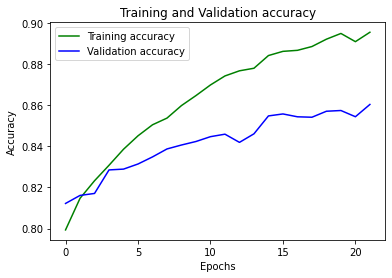

In [289]:
acc_train = hist.history['accuracy']
acc_val = hist.history['val_accuracy']
epochs = range(0,22)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

It is evident that with less epochs both the accuracy and validation accuracy increases while the loss on both sides is decreasing.

# Working with d2 Dataset - Iteratively Imputed

In [266]:
Xtv, Xt = train_test_split(d2, test_size=0.15, random_state=123, shuffle=True, stratify=None)
Ytv, Yt = train_test_split(Y2, test_size=0.15, random_state=123, shuffle=True, stratify=None)
print(Xtv.shape, Xt.shape, Ytv.shape, Yt.shape)

(187537, 113) (33095, 113) (187537, 1) (33095, 1)


In [267]:
Xtr, Xv = train_test_split(Xtv, test_size=0.15, random_state=123, shuffle=True, stratify=None)
Ytr, Yv = train_test_split(Ytv, test_size=0.15, random_state=123, shuffle=True, stratify=None)
print(Xtr.shape, Xv.shape, Ytr.shape, Yv.shape)

(159406, 113) (28131, 113) (159406, 1) (28131, 1)


# Decision Tree Classifier:

In [273]:
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt1 = DecisionTreeClassifier(**params_dt)

model_dt1.fit(Xtr,Ytr)

y_prd = model_dt1.predict(Xv)
accuracy_score(Yv,y_prd)


0.804379510148946

In [275]:
#Test Case Accuracy:
yt_prd = model_dt1.predict(Xt)
accuracy_score(Yt,yt_prd)

0.806315153346427

Thus the accuracy of decision tree classifier on Iteratively Imputed dataframe is **80.6%**

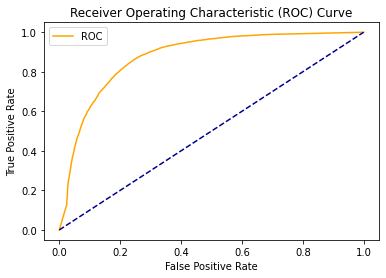

In [271]:
roc_auc = roc_auc_score(Yt, yt_prd)
probs = model_dt1.predict_proba(Xt)  
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(Yt, probs) 
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Random Forest Classifier:

In [272]:
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf1 = RandomForestClassifier(**params_rf)

In [276]:
model_rf1.fit(Xtr,Ytr)
y_prd1 = model_rf1.predict(Xv)
accuracy_score(Yv,y_prd1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


0.8597632505065586

In [277]:
y_prd = model_rf1.predict(Xt)
accuracy_score(Yt,y_prd)

0.8630004532406708

Thus the accuracy of Random Forest Classifier model is **86.3%**. Now we'll check for feature importance and thereby derive most prime features using which we will train and test the Random Forest classifier again.

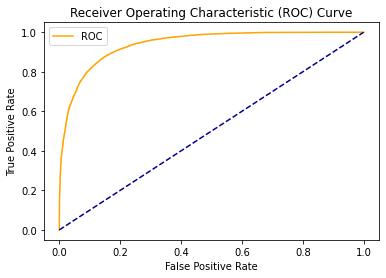

In [280]:
roc_auc = roc_auc_score(Yt, y_prd)
probs = model_rf1.predict_proba(Xt)  
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(Yt, probs) 
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# k-Nearest Neighbors Classifier:

In [279]:
from sklearn.neighbors import KNeighborsClassifier
knn_model1 = KNeighborsClassifier(n_neighbors = 11, weights = 'uniform', algorithm='ball_tree', leaf_size=30, p=2, metric='manhattan')
knn_model1.fit(Xtr,Ytr)
Y_pred = knn_model1.predict(Xv)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [281]:
accuracy_score(Yv,Y_pred)

0.7956702570118375

In [282]:
y_pred = knn_model1.predict(Xt)
accuracy_score(Yt,y_pred)

0.7979150929143375

The accuracy of k-NN classifier is merely **79%**

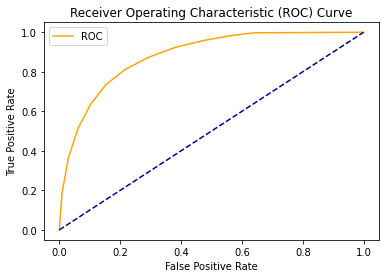

In [284]:
roc_auc = roc_auc_score(Yt, y_pred)
probs = knn_model1.predict_proba(Xt)  
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(Yt, probs) 
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()